In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import gdown
import zipfile


In [ ]:

# Load the GTSDB dataset
url = "https://drive.google.com/file/d/1xGBYnRgJkYVBnnQpTphWkmEyU77etqPd/view?usp=sharing"
output = "/content/GTSDB.zip"
gdown.download(url=url, output=output, fuzzy=True)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/')

gt_path = '/content/GTSDB/FullIJCNN2013/gt.txt'
images_path = Path('/content/GTSDB/FullIJCNN2013/FullIJCNN2013')
output_path = Path('/content/ProcessedImages')
augmented_path = Path('/content/AugmentedImages')

output_path.mkdir(parents=True, exist_ok=True)
augmented_path.mkdir(parents=True, exist_ok=True)

columns = ['Filename', 'LeftCol', 'TopRow', 'RightCol', 'BottomRow', 'ClassID']
gt_data = pd.read_csv(gt_path, sep=';', header=None, names=columns)

Downloading...
From (original): https://drive.google.com/uc?id=1xGBYnRgJkYVBnnQpTphWkmEyU77etqPd
From (redirected): https://drive.google.com/uc?id=1xGBYnRgJkYVBnnQpTphWkmEyU77etqPd&confirm=t&uuid=15b542ac-c8f7-41ed-b473-ae734affef3f
To: /content/GTSDB.zip
100%|██████████| 1.72G/1.72G [01:04<00:00, 26.5MB/s]


In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the segmentation model
segmentation_model_path = '/content/drive/My Drive/models/enhanced_unet_model.h5'
segmentation_model = load_model(segmentation_model_path, compile=False)

# Load the classifier model
#classifier_model_path = '/content/drive/My Drive/models/final_model_cnn_classifier_augmented.h5'
classifier_model_path = '/content/drive/MyDrive/models/final_model_cnn_classifier.h5'
classifier_model = load_model(classifier_model_path, compile=False)

In [ ]:
# Class ID to name mapping
class_id_to_name = {
    0: 'speed limit 20 (prohibitory)',
    1: 'speed limit 30 (prohibitory)',
    2: 'speed limit 50 (prohibitory)',
    3: 'speed limit 60 (prohibitory)',
    4: 'speed limit 70 (prohibitory)',
    5: 'speed limit 80 (prohibitory)',
    6: 'restriction ends 80 (other)',
    7: 'speed limit 100 (prohibitory)',
    8: 'speed limit 120 (prohibitory)',
    9: 'no overtaking (prohibitory)',
    10: 'no overtaking (trucks) (prohibitory)',
    11: 'priority at next intersection (danger)',
    12: 'priority road (other)',
    13: 'give way (other)',
    14: 'stop (other)',
    15: 'no traffic both ways (prohibitory)',
    16: 'no trucks (prohibitory)',
    17: 'no entry (other)',
    18: 'danger (danger)',
    19: 'bend left (danger)',
    20: 'bend right (danger)',
    21: 'bend (danger)',
    22: 'uneven road (danger)',
    23: 'slippery road (danger)',
    24: 'road narrows (danger)',
    25: 'construction (danger)',
    26: 'traffic signal (danger)',
    27: 'pedestrian crossing (danger)',
    28: 'school crossing (danger)',
    29: 'cycles crossing (danger)',
    30: 'snow (danger)',
    31: 'animals (danger)',
    32: 'restriction ends (other)',
    33: 'go right (mandatory)',
    34: 'go left (mandatory)',
    35: 'go straight (mandatory)',
    36: 'go right or straight (mandatory)',
    37: 'go left or straight (mandatory)',
    38: 'keep right (mandatory)',
    39: 'keep left (mandatory)',
    40: 'roundabout (mandatory)',
    41: 'restriction ends (overtaking) (other)',
    42: 'restriction ends (overtaking (trucks)) (other)'
}


In [ ]:
# Function to get ROIs from the segmentation mask
def get_rois_from_mask(mask, threshold=0.5):
    # Convert mask to binary
    binary_mask = (mask > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rois.append((x, y, w, h))

    return rois

def visualize_rois(image, rois, labels=None):
    num_plots = len(rois) + 1
    if num_plots == 1:
        fig, ax = plt.subplots(figsize=(15, 5))  # Create a single Axes
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title('Original Image')
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, num_plots, figsize=(15, 5))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        for i, (x, y, w, h) in enumerate(rois):
            roi = image[y:y+h, x:x+w]
            axes[i+1].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            title = f'ROI {i+1}'
            if labels:
                title += f'\nLabel: {labels[i]}'
            axes[i+1].set_title(title)
            axes[i+1].axis('off')

    plt.show()

# Function to classify ROIs
def classify_rois(rois):
    labels = []
    for roi in rois:
        x, y, w, h = roi
        roi_image = image[y:y+h, x:x+w]
        if roi_image.size == 0:
            continue
        roi_resized = cv2.resize(roi_image, (32, 32)) / 255.0  # Assuming the input size for the classifier is 32x32
        roi_expanded = np.expand_dims(roi_resized, axis=0)
        prediction = classifier_model.predict(roi_expanded)
        confidence = np.max(prediction)
        label_id = np.argmax(prediction, axis=1)[0]
        labels.append((class_id_to_name[label_id], confidence))
    return labels

# Function to draw bounding boxes with labels and confidence
def draw_bounding_boxes(image, rois, labels):
    for (x, y, w, h), (label, confidence) in zip(rois, labels):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label_text = f'{label} ({confidence:.2f})'
        cv2.putText(image, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2_imshow(image)


In [ ]:
# Test with a few images from the dataset
test_images = gt_data['Filename'].unique()[100:120]  # Using first 5 images for testing

In [ ]:
for img_name in test_images:
    img_path = str(images_path / img_name)
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, (512, 512)) / 255.0  # Assuming the input size for the model is 512x512

    # Predict the mask
    mask = segmentation_model.predict(np.expand_dims(image_resized, axis=0))[0]
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Get ROIs from the mask
    rois = get_rois_from_mask(mask_resized)

    # Classify the ROIs
    labels = classify_rois(rois)

    # Visualize the original image, ROIs, and classification labels
    visualize_rois(image, rois, labels)

In [ ]:
from google.colab.patches import cv2_imshow

for img_name in test_images:
    img_path = str(images_path / img_name)
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, (512, 512)) / 255.0  # Assuming the input size for the model is 512x512

    # Predict the mask
    mask = segmentation_model.predict(np.expand_dims(image_resized, axis=0))[0]
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Get ROIs from the mask
    rois = get_rois_from_mask(mask_resized)

    # Classify the ROIs
    labels = classify_rois(rois)

    # Draw bounding boxes and labels on the original image
    draw_bounding_boxes(image, rois, labels)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def process_frame(frame, segmentation_model, classifier_model):
    image_resized = cv2.resize(frame, (512, 512)) / 255.0  # Resize for segmentation model

    # Predict the mask
    mask = segmentation_model.predict(np.expand_dims(image_resized, axis=0))[0]
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))  # Resize mask back to original frame size

    # Get ROIs from the mask
    rois = get_rois_from_mask(mask_resized)

    # Classify the ROIs
    labels = classify_rois(rois)

    # Draw bounding boxes on the original frame
    draw_bounding_boxes(frame, rois, labels)

    return frame  # Return the frame with bounding boxes


In [ ]:
import cv2
from pathlib import Path

# Define el path del video de entrada y de salida
input_video_path = '/content/drive/MyDrive/videotest.mp4'
output_video_path = '/content/drive/MyDrive/videoIRLdetected.mp4'

# Inicializa la captura de video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

# Define las propiedades del video de salida
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % (5 * int(fps)) == 0:  # Procesa cada 2 segundos del video
        processed_frame = process_frame(frame, segmentation_model, classifier_model)

        # Mostrar el frame procesado
        cv2_imshow(processed_frame)  # Muestra el frame en el que se realizan detecciones

        # Guardar el frame en el video de salida
        out.write(processed_frame)
    else:
        # Guardar frames sin procesar también para mantener la continuidad del video
        out.write(frame)

    frame_count += 1

# Limpieza
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Video procesado guardado en: {output_video_path}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:

# Open a video stream
video_path = '/content/drive/MyDrive/videotest.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 15 == 0:  # Process every 15th frame
        processed_frame = process_frame(frame, segmentation_model, classifier_model)

        # Display the frame
        cv2_imshow(processed_frame)

    frame_count += 1

cap.release()
cv2.destroyAllWindows()

#Modelo Propio

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

In [ ]:
def get_rois_from_mask(mask, threshold=0.5):
    _, binary_mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(cnt) for cnt in contours]

def classify_rois(frame, rois):
    labels = []
    for x, y, w, h in rois:
        roi = frame[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, (32, 32))
        roi_normalized = roi_resized / 255.0
        roi_expanded = np.expand_dims(roi_normalized, axis=0)
        prediction = classifier_model.predict(roi_expanded)
        class_id = np.argmax(prediction)
        confidence = np.max(prediction)
        labels.append((class_id_to_name[class_id], confidence))
    return labels

def draw_bounding_boxes(frame, rois, labels):
    for (x, y, w, h), (label, confidence) in zip(rois, labels):
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label_text = f'{label} ({confidence:.2f})'
        cv2.putText(frame, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

def process_and_visualize_frame(frame, segmentation_model, classifier_model):
    # Resize y normalización para el modelo de segmentación
    image_resized = cv2.resize(frame, (512, 512))
    image_normalized = image_resized / 255.0

    # Predicción de la máscara
    mask = segmentation_model.predict(np.expand_dims(image_normalized, axis=0))[0]
    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Obtención de ROIs
    rois = get_rois_from_mask(mask_resized)
    labels = classify_rois(frame, rois, classifier_model)

    # Visualización de resultados
    visualize_frame_and_rois(frame, rois, labels)

    return frame


In [ ]:
video_paths = ['/content/drive/MyDrive/videoEE_000822-000900.mp4',
               '/content/drive/MyDrive/videoEE_000700-000820.mp4',
               '/content/drive/MyDrive/videoEE_000913-000940.mp4',
               '/content/drive/MyDrive/videoEE_000945-001100.mp4',
               '/content/drive/MyDrive/videoEE_001120-001200.mp4',
               '/content/drive/MyDrive/videoEE_000152-000255.mp4',
               '/content/drive/MyDrive/videoEE_000055-000121.mp4',
               '/content/drive/MyDrive/videoEE_000525-000600.mp4',
               '/content/drive/MyDrive/videoEE_000402-000425.mp4',
               '/content/drive/MyDrive/videoEE_000327-000400.mp4']

output_folder = '/content/drive/MyDrive/IRLDetections'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % (8 * int(fps)) == 0:  # Process every 10 seconds
            image_resized = cv2.resize(frame, (512, 512))
            image_normalized = image_resized / 255.0
            mask = segmentation_model.predict(np.expand_dims(image_normalized, axis=0))[0]
            mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
            rois = get_rois_from_mask(mask_resized)
            labels = classify_rois(frame, rois)
            draw_bounding_boxes(frame, rois, labels)
            cv2_imshow(frame)  # Show the frame with bounding boxes and labels

        frame_count += 1

    cap.release()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

def get_rois_from_mask(mask, threshold=0.5):
    _, binary_mask = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(cnt) for cnt in contours]

def visualize_and_classify_rois(frame, rois):
    for x, y, w, h in rois:
        roi = frame[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, (32, 32)) / 255.0  # Assuming the classifier expects 32x32 inputs
        roi_expanded = np.expand_dims(roi_resized, axis=0)
        prediction = classifier_model.predict(roi_expanded)
        class_id = np.argmax(prediction)
        confidence = np.max(prediction)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label_text = f'Class {class_id} ({confidence:.2f})'
        cv2.putText(frame, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2_imshow(roi)  # Display each ROI
        print(f"Class ID: {class_id}, Confidence: {confidence}")
    cv2_imshow(frame)  # Show the frame with bounding boxes and labels

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % (10 * int(fps)) == 0:  # Process every 10 seconds
            frame_resized = cv2.resize(frame, (512, 512))
            frame_normalized = frame_resized / 255.0
            mask = segmentation_model.predict(np.expand_dims(frame_normalized, axis=0))[0]
            mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
            rois = get_rois_from_mask(mask_resized)
            visualize_and_classify_rois(frame, rois)

        frame_count += 1

    cap.release()


In [30]:
video_paths = [
    '/content/drive/MyDrive/videoEE_000822-000900.mp4',
    '/content/drive/MyDrive/videoEE_000700-000820.mp4',
    '/content/drive/MyDrive/videoEE_000913-000940.mp4'
]

for video_path in video_paths:
    print(f"Processing video {video_path}")
    process_video(video_path)


Output hidden; open in https://colab.research.google.com to view.

In [31]:


import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Cargar modelos
segmentation_model = load_model('/content/drive/MyDrive/models/enhanced_unet_model.h5', compile=False)

# Directorio donde guardar los ROIs
roi_directory = '/content/drive/MyDrive/ROIsPersonal'
os.makedirs(roi_directory, exist_ok=True)


In [34]:
def get_rois_from_mask(mask, threshold=0.5):
    _, binary_mask = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(cnt) for cnt in contours]

def save_and_show_rois(frame, rois, video_name, frame_count):
    for i, (x, y, w, h) in enumerate(rois):
        roi = frame[y:y+h, x:x+w]
        roi_filename = f"{video_name}_frame{frame_count}_roi{i}.jpg"
        roi_path = os.path.join(roi_directory, roi_filename)

        # Convertir ROI a JPEG en memoria antes de guardar
        _, buffer = cv2.imencode('.jpg', roi)
        roi_jpg = cv2.imdecode(buffer, 1)  # Decodificar a imagen nuevamente para mostrar

        # Mostrar la imagen
        print(f"Showing: {roi_filename}")
        cv2_imshow(roi_jpg)

        # Guardar la imagen
        cv2.imwrite(roi_path, roi_jpg)
        print(f"Saved: {roi_path}")

def process_video_and_save_rois(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    video_name = os.path.basename(video_path).split('.')[0]  # Obtener nombre de archivo sin extensión

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % (10 * int(fps)) == 0:  # Procesar cada 10 segundos
            frame_resized = cv2.resize(frame, (512, 512))
            frame_normalized = frame_resized / 255.0
            mask = segmentation_model.predict(np.expand_dims(frame_normalized, axis=0))[0]
            mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
            rois = get_rois_from_mask(mask_resized)
            save_and_show_rois(frame, rois, video_name, frame_count)

        frame_count += 1

    cap.release()


Processing video /content/drive/MyDrive/videoEE_000822-000900.mp4
1/1 [==============================] - 0s 28ms/step
Showing: videoEE_000822-000900_frame0_roi0.jpg


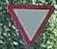

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000822-000900_frame0_roi0.jpg
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000822-000900_frame300_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000822-000900_frame300_roi0.jpg
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000822-000900_frame900_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000822-000900_frame900_roi0.jpg
Processing video /content/drive/MyDrive/videoEE_000700-000820.mp4
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000700-000820_frame900_roi0.jpg


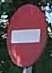

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000700-000820_frame900_roi0.jpg
Showing: videoEE_000700-000820_frame900_roi1.jpg


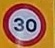

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000700-000820_frame900_roi1.jpg
Showing: videoEE_000700-000820_frame900_roi2.jpg


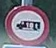

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000700-000820_frame900_roi2.jpg
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_000700-000820_frame1200_roi0.jpg


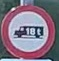

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000700-000820_frame1200_roi0.jpg
Showing: videoEE_000700-000820_frame1200_roi1.jpg


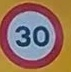

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000700-000820_frame1200_roi1.jpg
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_000700-000820_frame1800_roi0.jpg


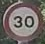

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000700-000820_frame1800_roi0.jpg
1/1 [==============================] - 0s 28ms/step
Processing video /content/drive/MyDrive/videoEE_000913-000940.mp4
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_000913-000940_frame600_roi0.jpg


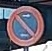

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000913-000940_frame600_roi0.jpg
Showing: videoEE_000913-000940_frame600_roi1.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000913-000940_frame600_roi1.jpg
Showing: videoEE_000913-000940_frame600_roi2.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000913-000940_frame600_roi2.jpg
Processing video /content/drive/MyDrive/videoEE_000945-001100.mp4
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_000945-001100_frame0_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000945-001100_frame0_roi0.jpg
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000945-001100_frame1800_roi0.jpg


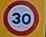

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000945-001100_frame1800_roi0.jpg
1/1 [==============================] - 0s 26ms/step
Processing video /content/drive/MyDrive/videoEE_001120-001200.mp4
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_001120-001200_frame0_roi0.jpg


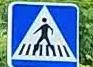

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame0_roi0.jpg
1/1 [==============================] - 0s 28ms/step
Showing: videoEE_001120-001200_frame600_roi0.jpg


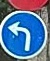

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame600_roi0.jpg
Showing: videoEE_001120-001200_frame600_roi1.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame600_roi1.jpg
1/1 [==============================] - 0s 29ms/step
Showing: videoEE_001120-001200_frame900_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame900_roi0.jpg
Showing: videoEE_001120-001200_frame900_roi1.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame900_roi1.jpg
Showing: videoEE_001120-001200_frame900_roi2.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame900_roi2.jpg
Showing: videoEE_001120-001200_frame900_roi3.jpg


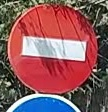

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame900_roi3.jpg
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_001120-001200_frame1200_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame1200_roi0.jpg
Showing: videoEE_001120-001200_frame1200_roi1.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame1200_roi1.jpg
Showing: videoEE_001120-001200_frame1200_roi2.jpg


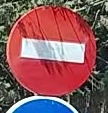

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_001120-001200_frame1200_roi2.jpg
Processing video /content/drive/MyDrive/videoEE_000152-000255.mp4
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_000152-000255_frame1500_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000152-000255_frame1500_roi0.jpg
Showing: videoEE_000152-000255_frame1500_roi1.jpg


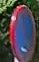

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000152-000255_frame1500_roi1.jpg
1/1 [==============================] - 0s 26ms/step
Showing: videoEE_000152-000255_frame1800_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000152-000255_frame1800_roi0.jpg
Showing: videoEE_000152-000255_frame1800_roi1.jpg


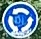

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000152-000255_frame1800_roi1.jpg
Showing: videoEE_000152-000255_frame1800_roi2.jpg


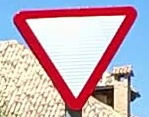

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000152-000255_frame1800_roi2.jpg
Processing video /content/drive/MyDrive/videoEE_000055-000121.mp4
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000055-000121_frame0_roi0.jpg


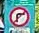

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000055-000121_frame0_roi0.jpg
1/1 [==============================] - 0s 27ms/step
Processing video /content/drive/MyDrive/videoEE_000525-000600.mp4
1/1 [==============================] - 0s 25ms/step
Processing video /content/drive/MyDrive/videoEE_000402-000425.mp4
1/1 [==============================] - 0s 28ms/step
Processing video /content/drive/MyDrive/videoEE_000327-000400.mp4
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000327-000400_frame300_roi0.jpg


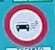

Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000327-000400_frame300_roi0.jpg
1/1 [==============================] - 0s 27ms/step
Showing: videoEE_000327-000400_frame600_roi0.jpg


Saved: /content/drive/MyDrive/ROIsPersonal/videoEE_000327-000400_frame600_roi0.jpg
1/1 [==============================] - 0s 25ms/step


In [35]:
video_paths = ['/content/drive/MyDrive/videoEE_000822-000900.mp4',
               '/content/drive/MyDrive/videoEE_000700-000820.mp4',
               '/content/drive/MyDrive/videoEE_000913-000940.mp4',
               '/content/drive/MyDrive/videoEE_000945-001100.mp4',
               '/content/drive/MyDrive/videoEE_001120-001200.mp4',
               '/content/drive/MyDrive/videoEE_000152-000255.mp4',
               '/content/drive/MyDrive/videoEE_000055-000121.mp4',
               '/content/drive/MyDrive/videoEE_000525-000600.mp4',
               '/content/drive/MyDrive/videoEE_000402-000425.mp4',
               '/content/drive/MyDrive/videoEE_000327-000400.mp4']

for video_path in video_paths:
    print(f"Processing video {video_path}")
    process_video_and_save_rois(video_path)
